# Quantum Approximate Optimization Algorithm

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_quantum_approximate_optimization_algorithm.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_quantum_approximate_optimization_algorithm.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/case_library/quantum_approximate_optimization_algorithm.ipynb)

## Overview

Quantum approximate optimization algorithm (QAOA) is a quantum algorithm that uses quantum computers to solve combination optimization problems. It was first proposed by Farhi et al. in 2014. In this tutorial, we will use QAOA to solve the Max-Cut problem and get familiar with the construction and training of quantum circuits in MindSpore Quantum.

## Environment Preparation

This tutorial requires the following library:

- networkx

> `NetworkX` is a library for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. You can install it with:

```bash
pip3 install networkx
```

## Max-Cut Problem Description

The Max-Cut problem is an NP-complete problem in the graph theory. It needs to divide vertices of a graph into two parts and make the most edges be cut. As shown in the following figure (a), a graph consists of five vertices, and the interconnected edges are ```(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), and (0, 4)```. To maximize the number of edges to be cut, we divide 1, 2, and 4 into one group, and 0 and 3 into another group, as shown in the figure (b). Therefore, five edges are to be cut. When the number of vertices in a graph increases, it is difficult to find an effective typical algorithm to solve the Max-Cut problem. The following describes how to transform the Max-Cut problem into a Hamiltonian ground state capability solution problem.

![max cut](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/Max_Cut.png)

## Max-Cut Problem Quantization

Assign each vertex a quantum bit. If the vertex is allocated to the left side, its quantum bit is set to the $\left|0\right>$ state. If the vertex is on the right side, its quantum bit is set to the $\left|1\right>$ state. When two vertices are in different sets, the bits on the two vertices are in different quantum states. For the vertex 0 and the vertex 1, when their connection line is cut, quantum states corresponding to bits on the two vertices may be $|01\rangle$ (vertax 1: left, vertax 0: right) or $|10\rangle$ (vertax 1: right, vertax 0: left). If they are partitioned to the same side, the corresponding quantum state is $|00\rangle$ or $|11\rangle$. So we just need to find a Hamiltonian $H$ that makes the expectation value of the Hamiltonian to -1 when there are connected two vertices in different quantum states, i.e.

$$
\langle 01|H|01\rangle=-1,\quad \langle 10|H|10\rangle=-1
$$

When vertices are in the same quantum state, the expected value of Hamiltonian quantity is 0, i.e

$$
\langle 00|H|00\rangle=0,\quad \langle 11|H|11\rangle=0
$$

Subsequently the maximum number of cut edges, and the corresponding grouping case at that point, can be found by simply minimizing the expected value of the Hamiltonian quantity. The reason why the expected value at different quantum states is set to -1 is that in the training of the quantum neural network, the gradient of the parameters in Ansatz keeps decreasing, and also the measured value keeps decreasing. The training method is aimed at finding the minimum value, and here we use it to find the ground state energy of the Hamiltonian quantity. At this point, we choose the Hamiltonian $H=(Z_1Z_0-1)/2$, where $Z$ is the Pauli $Z$ operator. We can see that:

$$
Z_1Z_0|00\rangle=|00\rangle,\quad Z_1Z_0|11\rangle=|11\rangle, \quad Z_1Z_0|01\rangle=-|01\rangle, \quad Z_1Z_0|10\rangle=-|10\rangle
$$

Thus when the vertices are partitioned into different sets:

$$
\left<01\right|H\left|01\right>=\frac{1}{2}\left<01\right|Z_1Z_0\left|01\right>-\frac{1}{2}=-1
$$

$$
\left<10\right|H\left|10\right>=\frac{1}{2}\left<10\right|Z_1Z_0\left|10\right>-\frac{1}{2}=-1
$$

And when the vertices are partitioned into the same set, it is not difficult to verify that:

$$
\left<00\right|H\left|00\right>=\frac{1}{2}\left<00\right|Z_1Z_0\left|00\right>-\frac{1}{2}=0
$$

$$
\left<11\right|H\left|11\right>=\frac{1}{2}\left<11\right|Z_1Z_0\left|11\right>-\frac{1}{2}=0
$$

Therefore, we just write the above Hamiltonian for each edge in the graph and then sum up all the edges to write the Hamiltonian $H$ corresponding to the graph. Using a quantum computer to find the ground state energy and ground state of $H$, we can get the Max-Cut cutting scheme and the maximum number of cutting edges of the graph. We write down the set of all edges as $C$ and the number of all edge strips as $c$, then the Hamiltonian quantity can be written as:

$$
H=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

## Importing Dependencies


In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, Rzz, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

## Building a Graph to Be Solved

Use `add_path` to add edges to a graph. Then, the graph structure is drawn.

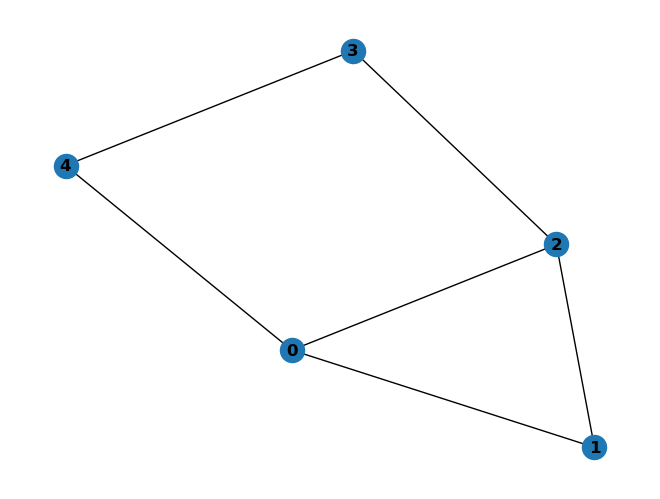

In [2]:
graph = nx.Graph()
nx.add_path(graph, [0, 1])
nx.add_path(graph, [1, 2])
nx.add_path(graph, [2, 3])
nx.add_path(graph, [3, 4])
nx.add_path(graph, [0, 4])
nx.add_path(graph, [0, 2])
nx.draw(graph, with_labels=True, font_weight='bold')

As shown in the preceding figure, a graph structure consisting of five vertices and six edges is obtained.

Next we use the exhaustive method to see the number of cutting edges for all cases.

In [3]:
for i in graph.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(graph, [i]))            # All cases with 1 node in one group and 4 nodes in the other group
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(graph, [i, j]))  # All cases with 2 nodes in one group and 3 nodes in the other group

one size: [0] cut= 3
one size: [1] cut= 2
one size: [1, 0] cut= 3
one size: [2] cut= 3
one size: [2, 0] cut= 4
one size: [2, 1] cut= 3
one size: [3] cut= 2
one size: [3, 0] cut= 5
one size: [3, 1] cut= 4
one size: [3, 2] cut= 3
one size: [4] cut= 2
one size: [4, 0] cut= 3
one size: [4, 1] cut= 4
one size: [4, 2] cut= 5
one size: [4, 3] cut= 2


From the above results, it can be seen that the maximum number of cutting edges obtained by the exhaustive method is 5. If a distinction is made between the left and right of the node grouping, there are a total of 4 grouping methods that maximize the number of cutting edges, i.e., there are 4 simplex solutions to the problem.

## The Process of QAQA Algorithm

1. Build a QAOA quantum circuit, where the ansatz circuit contains parameters that can be trained
2. Initialize the parameters in the circuit
3. Run this quantum circuit and get the quantum state $|\psi\rangle$
4. Compute the expected value $\langle\psi|H_C|\psi\rangle$ of the target Hamiltonian $H_C$
5. Based on the results of step 4, use the Adam optimizer to optimize the parameters in the circuit
6. Repeat steps 3-5 until the results in step 4 are basically unchanged
7. Based on the result of step 4, the approximate solution of the target problem is calculated

In this process, steps 2-6 can all be implemented by packages and functions available in MindSpore and MindSpore Quantum, so we will focus on step 1: building the quantum circuit.

![Flowchart](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/QAOA_Flowchart.png)

## Setting up a QAOA Quantum Circuit

As mentioned previously, we need to combine the Hamiltonian quantities corresponding to the problem:

$$
H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

Minimization to find the solution of the problem, which means we have to find the ground state of that Hamiltonian quantity. We can use quantum adiabatic evolution to make the system first on the ground state of some simple Hamiltonian $H_B$, and then make the simple Hamiltonian $H_B$ evolve adiabatically and slowly to some complex Hamiltonian $H_C$. According to the adiabatic theorem, the system will always remain on the ground state of the Hamiltonian, and finally reach the ground state of the complex Hamiltonian $H_C$.

The quantum circuit we are going to build is using the above idea, choosing the initial simple Hamiltonian quantity as:

$$
H_B=\sum_i -X_i
$$

Prepare the quantum circuit to the ground state $|s\rangle=|+\rangle^{\otimes n}$ of $H_B$, which can be achieved here by acting [Hadamard](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate on all quantum bits. Then the ansatz circuits are connected, and by continuously optimizing the parameters, the ansatz circuits can be made closer to the real adiabatic evolution, and the finally obtained quantum circuits can be regarded as simulating a real adiabatic evolution.

### ansatz Circuit

In the quantum adiabatic evolution, the initial Hamiltonian quantities are first selected

$$
H_B=\sum_i -X_i
$$

Put the system in the $H_B$ ground state $|s\rangle=|+\rangle^{\otimes n}$. Then slowly act on the following time-dependent Hamiltonian:

$$
H(t)=(1-\frac{t}{T})H_B+(\frac{t}{T})H_C
$$

Notice that $H(T)=H_C$ when $t=T$. When the chosen $T$ is large enough (satisfying the adiabatic condition), the system will always be on the instantaneous ground state of $H(t)$, when the quantum state of the system will evolve adiabatically from the ground state $|\psi (0)\rangle$ of the initial Hamiltonian $H_B$ to the ground state $|\psi (T)\rangle$ of the target Hamiltonian $H_C$, i.e.

$$
|\psi (T)\rangle=\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}|\psi(0)\rangle
$$

That is, the ansatz circuit needs to model the evolution process $\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}$. Next we will make some approximations and simplifications to this equation to make it into a form that can be implemented in quantum circuits.

Considering the following trotter formula:

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}=\lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH(t_l)\Delta t},\quad \Delta t=\frac{T}{N},\quad t_l=l\Delta t
$$

Omitting the $O(\Delta t^2)$ term, we obtain:

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}\approx \lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH_B(1-t_l/T)\Delta t}e^{-iH_C t_l\Delta t/T}
$$

Let $\beta_l=(1-t_l/T)\Delta t$, $\gamma_l=t_l\Delta t/T$, and take $N$ as a finite large integer, that is, the ansatz of QAOA is obtained:

$$
|\psi(\gamma,\beta)\rangle=\prod^p_{l=1}e^{-i\beta_l H_B}e^{-i\gamma_l H_C}|\psi_{in}\rangle
$$

Thus the ansatz line we need to build consists of $U_C(\gamma)$ and $U_B(\beta)$ which alternate the two unitary transformations, where $U_C(\gamma)=e^{-i\frac{\gamma}{2} \sum_{\langle i,j\rangle}Z_i Z_j}$ can be implemented by the [Rzz](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.Rzz.html) gate. $U_B(\beta)=e^{i\beta \sum_i X_i}$ is then equivalent to acting a [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) revolving gate on each quantum bit, with $\gamma$ and $\beta$ as trainable parameters.

Build the quantum circuit corresponding to $U_C(\gamma)$:

In [4]:
def build_hc(g, para):
    hc = Circuit()                  # Build quantum circuit
    for i in g.edges:
        hc += Rzz(para).on(i)       # Act Rzz gate on each edge of the diagram
    hc.barrier()                    # Add Barrier for easy display of circuits
    return hc

Display the circuits:

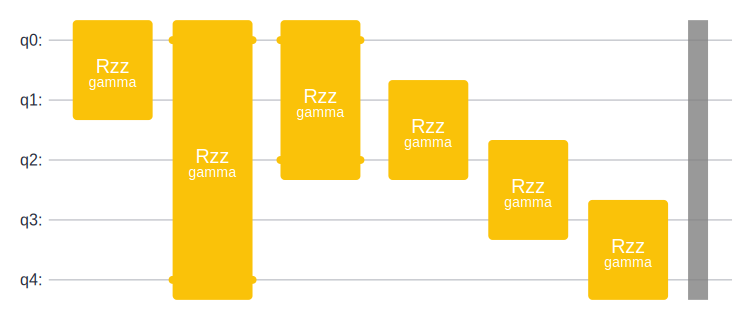

In [5]:
# pylint: disable=W0104
circuit = build_hc(graph, 'gamma')
circuit.svg()

Build the quantum circuits corresponding to $U_B(\beta)$:

In [6]:
def build_hb(g, para):
    hb = Circuit()              # Build quantum circuit
    for i in g.nodes:
        hb += RX(para).on(i)    # Act RX gate on each node
    hb.barrier()                # Add Barrier for easy display of circuits
    return hb

Display the circuits:

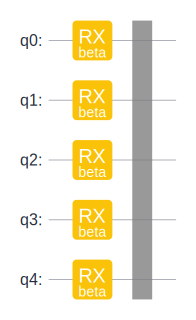

In [7]:
# pylint: disable=W0104
circuit = build_hb(graph, 'beta')
circuit.svg()

The ansatz circuit that implements a layer of unitary transform $U_B(\beta) U_C(\gamma)$ is shown below:

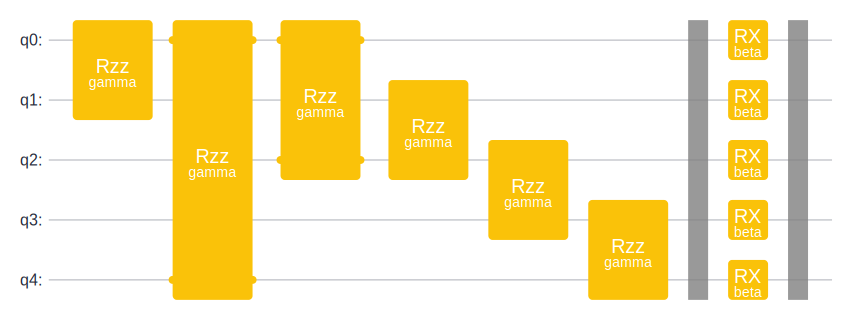

In [8]:
# pylint: disable=W0104
circuit = build_hc(graph, 'gamma') + build_hb(graph, 'beta')
circuit.svg()

In order to make the final optimization result accurate enough, we need to repeat the quantum circuit several times, so we build a multilayer training network by the following function:

In [9]:
# g is the graph of the max-cut problem, and p is the number of layers of the ansatz circuit
def build_ansatz(g, p):
    circ = Circuit()  # Build quantum circuit
    for i in range(p):
        # Add the circuit corresponding to Uc, with parameters noted as g0, g1, g2...
        circ += build_hc(g, f'g{i}')

        # Add the circuit corresponding to Ub, with parameters noted as b0, b1, b2...
        circ += build_hb(g, f'b{i}')
    return circ

The Hamiltonian quantity $H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$ corresponding to construction graph(ignoring the constant terms and coefficients).

In [10]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # Generate hamiltonian Hc
    return ham

### Generating a Complete Quantum Circuit and the Hamiltonian Corresponding to the Graph

In this example, `p = 4` is selected, indicating that the four-layer QAOA quantum circuit is used. `ansatz` is a quantum circuit for solving the problem, and `init_state_circ` is a quantum circuit for preparing a quantum state on a uniformly superposed state.

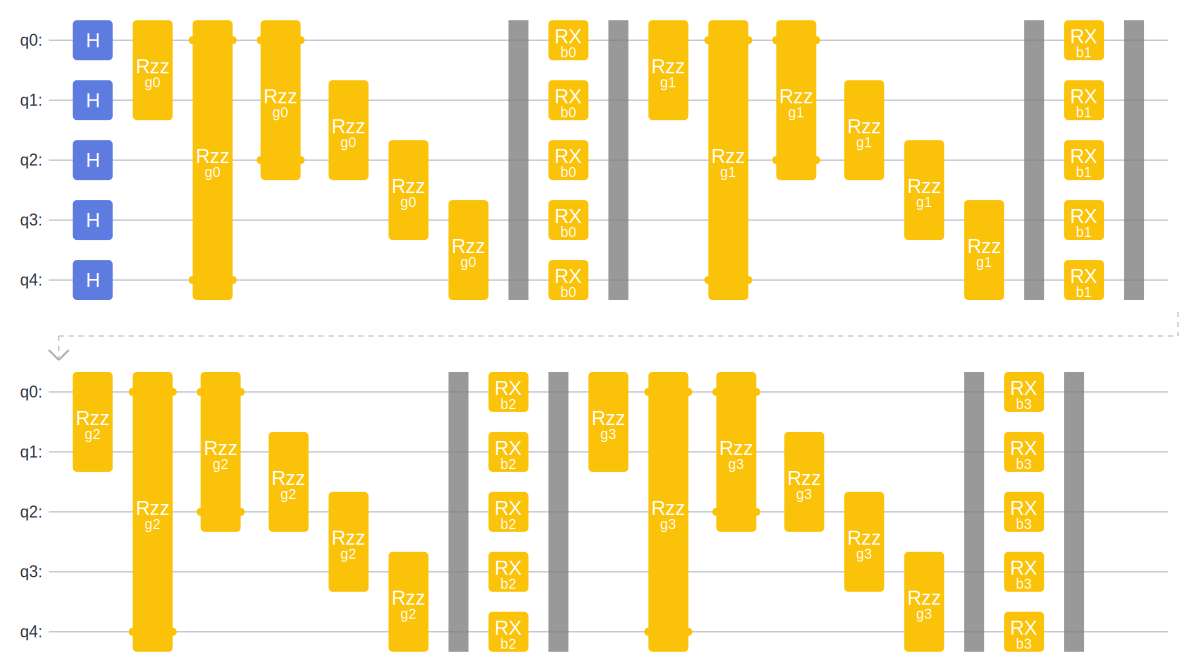

In [11]:
# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(graph))     # Generate Hamiltonian quantities
init_state_circ = UN(H, graph.nodes)    # Generate uniform superposition states, i.e., act H-gate on all quantum bits
ansatz = build_ansatz(graph, p)         # Generate ansatz circuit
circ = init_state_circ + ansatz         # Combine the initialized circuit and the ansatz circuit into one circuit
circ.svg(width=1200)

## Approach One: Use Traditional Optimization Method

### Generating Gradient Operator

First, we use a simulator to generate computational operators for calculating expectations and gradients of QAOA variational quantum circuit.

In [12]:
sim = Simulator('mqvector', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circ)

`grad_ops` is a operator to calculate the expectation and gradient. For example, we can use this operator to calculate the expectation and gradient at `p0`.

In [13]:
import numpy as np

rng = np.random.default_rng(10)
p0 = rng.random(size=len(circ.params_name)) * np.pi * 2 - np.pi
f, g = grad_ops(p0)
print('Expectation Value: ', f)
print('Expectation Value Shape: ', f.shape)
print('Gradient: ', g)
print('Gradient Shape: ', g.shape)

Expectation Value:  [[2.2839928+4.88195544e-17j]]
Expectation Value Shape:  (1, 1)
Gradient:  [[[ 0.60966156+0.j -0.50977303+0.j  1.96920626+0.j -1.89443604+0.j
    0.9840882 +0.j -1.85238736+0.j  1.27387126+0.j -0.03135037+0.j]]]
Gradient Shape:  (1, 1, 8)


Here, we get the expectation values as an $(m=1,n=1)$-dimensional array, where $m$ represents how many data points were encoded into a quantum state during this computation. Since QAOA tasks do not require an encoder, the default value for $m$ is 1. Meanwhile, $n$ represents how many Hamiltonian expectation values were computed in this operation (MindQuantum supports parallel processing of multiple Hamiltonians). In this case, we only calculate the expectation value for `ham`, so $n=1$. Similarly, for the gradient values, their dimensions are $(m=1,n=1,k=8)$, where the additional dimension $k=8$ represents the number of ansatz variational parameters in the entire circuit.

We introduce the second-order optimizer BFGS from scipy to optimize the Max-Cut problem. To do this, we first define the function to be optimized:

In [14]:
# pylint: disable=W0604
global step
step = 0


def fun(p, grad_ops):
    global step
    f, g = grad_ops(p)
    f = np.real(f)[0, 0]
    g = np.real(g)[0, 0]
    step += 1
    if step % 10 == 0:
        print(f"train step: {step} , cut: [{(len(graph.edges) - f) / 2}]")
    return f, g


fun(p0, grad_ops)

(2.2839927952206174,
 array([ 0.60966156, -0.50977303,  1.96920626, -1.89443604,  0.9840882 ,
        -1.85238736,  1.27387126, -0.03135037]))

### Training Process

`BFGS` is a second-order optimizer that performs well. By specifying `jac=True`, you are telling the optimizer that the function to be optimized will return both the function value and the gradient at the same time. If set to `False`, the optimizer will use finite differences to approximate the gradient on its own, which can be computationally expensive.

In [15]:
from scipy.optimize import minimize

step = 0
res = minimize(fun, p0, args=(grad_ops, ), method='bfgs', jac=True)

train step: 10 , cut: [3.5103176644442238]
train step: 20 , cut: [3.868695972469235]
train step: 30 , cut: [4.194720830469368]
train step: 40 , cut: [4.649109856438022]
train step: 50 , cut: [4.752059940467564]
train step: 60 , cut: [4.777656304269479]
train step: 70 , cut: [4.820166856240324]
train step: 80 , cut: [4.825019042509073]
train step: 90 , cut: [4.826176814772741]


At the optimal solution, the variational parameters obtained from training are:

In [16]:
print(dict(zip(circ.params_name, res.x)))

{'g0': -0.7937405245633787, 'b0': 0.24377670109607055, 'g1': 1.6118673525265843, 'b1': -2.0908435247717794, 'g2': -0.21919996577600231, 'b2': -1.955308095101507, 'g3': 1.2663769844140762, 'b3': 2.752892656008665}


## Approach two: Use MindSpore to Train Quantum Neural Network

### Building a Quantum Neural Network to Be Trained

This problem does not require a coding-layer quantum circuit, so we use [MQAnsatzOnlyLayer](https://www.mindspore.cn/mindquantum/docs/en/master/framework/layer/mindquantum.framework.MQAnsatzOnlyLayer.html) as a quantum neural network to be trained and an [Adam](https://www.mindspore.cn/docs/en/master/api_python/nn/mindspore.nn.Adam.html) optimizer.

In [17]:
import mindspore as ms

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('mqvector', circ.n_qubits)    # Create a simulator, backend uses 'mqvector' and can simulate 5 bits (the number of bits contained in the 'circ' line)

# Obtain the operator to calculate the expectation and gradient of the variational quantum circuit
grad_ops = sim.get_expectation_with_grad(ham, circ)

# Generate the neural network to be trained
net = MQAnsatzOnlyLayer(grad_ops)

# Set the Adam optimizer for all trainable parameters in the network with a learning rate of 0.05
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)

# One-step training of neural networks
train_net = nn.TrainOneStepCell(net, opti)

### Training and Displaying Results

In [18]:
for i in range(200):
    # Train the neural network for one step and calculate the result (number of cut edges). Note: Every time 'train_net()' is run, the neural network is trained for one step
    cut = (len(graph.edges) - train_net()) / 2
    if i % 10 == 0:
        print("train step:", i, ", cut:", cut)   # For every 10 training steps, print the current number of training steps and the current number of cutting edges obtained

train step: 0 , cut: [3.0004191]
train step: 10 , cut: [4.440877]
train step: 20 , cut: [4.699215]
train step: 30 , cut: [4.7900705]
train step: 40 , cut: [4.8516107]
train step: 50 , cut: [4.8745494]
train step: 60 , cut: [4.89936]
train step: 70 , cut: [4.9250917]
train step: 80 , cut: [4.938618]
train step: 90 , cut: [4.937195]
train step: 100 , cut: [4.9391575]
train step: 110 , cut: [4.939012]
train step: 120 , cut: [4.9392276]
train step: 130 , cut: [4.939231]
train step: 140 , cut: [4.9392524]
train step: 150 , cut: [4.9392548]
train step: 160 , cut: [4.9392567]
train step: 170 , cut: [4.939257]
train step: 180 , cut: [4.939257]
train step: 190 , cut: [4.939257]


Based on the above training results, we find that the number of cut edges corresponding to the ground state energy of Hamiltonian is close to 5.

### Optimal Parameter

Previously, we obtained the optimal values of the parameters in the quantum circuit by training. In the following, we extract the optimal parameters and store them as dictionary types, which correspond to the parameters named in the previous circuit.

In [19]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy()))  # Obtain circuit parameters
print(pr)

{'g0': 0.44889548, 'b0': -1.1389917, 'g1': 0.9062595, 'b1': -0.94462746, 'g2': 1.0675684, 'b2': -0.6775048, 'g3': 1.1679738, 'b3': -0.38228452}


### Probabilistic Graph

We substitute the optimal parameters into the quantum circuit and draw the probability distribution of the final quantum state under the computed vector by sampling the quantum circuit 1000 times:

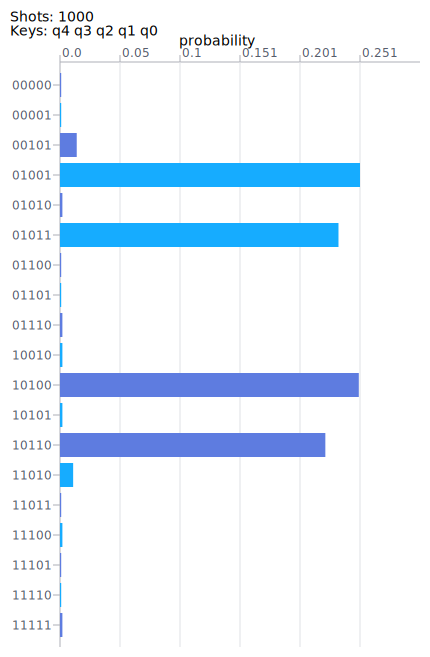

In [20]:
# pylint: disable=W0104
circ.measure_all()                            # Add measurement gates for all bits in the circuit
sim.sampling(circ, pr=pr, shots=1000).svg()   # Run the circuit 1000 times and print the results


According to the probability distribution diagram, the Max-Cut problem has four degenerate solutions, and the probability corresponding to each solution is about 25%.

- `01001`: The vertices numbered 1, 2, and 4 are on the left, and the vertices numbered 0 and 3 are on the right.
- `10110`: The vertices numbered 0 and 3 are on the left, and the vertices numbered 1, 2, and 4 are on the right.
- `01011`: The vertices numbered 2 and 4 are on the left, and the vertices numbered 0, 1, and 3 are on the right.
- `10100`: The vertices numbered 0, 1, and 3 are on the left, and the vertices numbered 2 and 4 are on the right.

It can be found that the above results are consistent with the previous results obtained by the exhaustive method.

## Summary

We use the quantum approximation optimization algorithm to solve the Max-Cut problem and obtain the Max-Cut solution corresponding to the graph in the case.

In [21]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.21.6
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Mon Oct 30 20:17:07 2023


## References

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)